In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab
from pylab import figure, subplot, text, xlim, ylim, title, plot, axvline, ylabel, xlabel, legend
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, describe, spearmanr
import scipy.stats as stats
import statsmodels.api as sm
import pylab as py

In [2]:
import os
os.environ['PATH'] = "/software/texlive/2020/bin/x86_64-linux:" + os.environ['PATH']

matplotlib.rcParams['text.usetex'] = False

In [3]:
orig_params = pylab.rcParams.copy()
params = {'legend.fontsize': '20',
          'figure.figsize': (15, 10),
          'axes.labelsize': '20',
          'axes.titlesize':'25',
          'xtick.labelsize':'20',
          'ytick.labelsize':'20',
          'axes.linewidth': '0.5',
          'pdf.fonttype': '42'}
pylab.rcParams.update(params)
# pylab.style.use('seaborn-white')

In [35]:
#PARAM VALS FOR THIS RUN
# sim_file_use = '/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_ec50_equals_median_kOn_added/k_Tf_on/samples_replicates_over_time_with_regulation_param_index_9_run_9.csv'
sim_file_use = '/home/mzo5929/Keerthana/grnInference/simulation_data/gillespie_simulation_run_0/neg_reg/df_06072025_015325_ncells_10000_row_18020_18021_a481f069.csv'
# sim_file_use = '/home/mzo5929/Keerthana/grnInference/simulation_data/general_simulation_data/test/simulation_matrix101_A_B_different_params_0_11_regular_time_step.csv'
# sim_file_use = '/home/mzo5929/Keerthana/grnInference/simulationData/simulations_rerun/with_regulation/median/samples_replicates_with_regulation_median_0.csv'
num_sampling_times = 24
num_cells = 10e3

updated_df = pd.read_csv(sim_file_use)
updated_df

,cell_id,time_step,gene_1_mRNA,gene_1_protein,gene_2_mRNA,gene_2_protein,replicate,clone_id
0,0,0,0,18,0,634,1,0
1,0,1,0,16,0,603,1,0
2,0,2,0,13,0,574,1,0
3,0,3,0,13,1,712,1,0
4,0,4,0,11,1,1098,1,0
...,...,...,...,...,...,...,...,...
959995,19999,43,1,15,1,1555,2,9999
959996,19999,44,0,14,1,1877,2,9999
959997,19999,45,0,11,1,2166,2,9999
959998,19999,46,0,9,1,2438,2,9999


In [5]:
def calculate_protein_level_with_regulation(params, hill_response=0.0, r_add=10, 
                                          splicing_half_life=7/60):
    """
    Calculate steady-state protein level given gene parameters and regulatory input.
    
    Args:
        params (array-like): Gene parameters in order:
            [k_on, k_off, burst_size, mrna_half_life, protein_half_life, protein_production_rate]
        hill_response (float): Desired Hill function output (0-1)
            0 = no regulation, 1 = maximum activation
        r_add (float): Maximum regulatory effect strength (default 10)
        splicing_half_life (float): mRNA maturation time (hours, default 7 min)
    
    Returns:
        float: Steady-state protein level
    """
    
    # Unpack parameters in order
    k_on, k_off, burst_size, mrna_half_life, protein_half_life, protein_production_rate = params
    
    # Convert half-lives to degradation rates
    mrna_deg_rate = np.log(2) / mrna_half_life
    protein_deg_rate = np.log(2) / protein_half_life
    splicing_rate = np.log(2) / splicing_half_life
    
    # Calculate transcription rate from burst parameters
    transcription_rate = burst_size * k_off
    
    
    # Apply regulation: k_on_eff = k_on + r_add * hill_response
    k_on_eff = k_on + r_add * hill_response
    k_on_eff = max(k_on_eff, 1e-10)  # Ensure positive
    
    # Calculate steady-state levels through the cascade
    # 1. Bursting probability
    burst_prob = k_on_eff / (k_on_eff + k_off)
    
    # 2. Unspliced mRNA level
    unspliced_mrna = transcription_rate * burst_prob / (mrna_deg_rate + splicing_rate)
    
    # 3. Spliced mRNA level  
    spliced_mrna = unspliced_mrna * splicing_rate / mrna_deg_rate
    
    # 4. Protein level
    protein_level = spliced_mrna * protein_production_rate / protein_deg_rate
    # print(unspliced_mrna + spliced_mrna)
    return protein_level

In [7]:
r_add = 1
r_add

1

In [8]:
params_gene_1 = [0.4023188424412684,69.57850258396365,29.902655460974103,4.9676607542185085,17.514301786039532,0.029712484672261147]
params_gene_2 = [0.2127851341068382,31.933683905796215,79.28488335937969,5.548348142938958,88.7951704914292,0.14608750436112627]
# params_gene_1 = [0.27,8.4,32.0,2.5,28.0,0.059]
# params_gene_2 = [0.25,7.7,40.0,3.7,28,0.059]

# Calculate equations for gene_1
baseline_gene_1 = calculate_protein_level_with_regulation(params_gene_1, splicing_half_life=7/60)
K_gene_1 = calculate_protein_level_with_regulation(params_gene_1, r_add=r_add, hill_response=0.5, splicing_half_life=7/60)
maximal_gene_1 = calculate_protein_level_with_regulation(params_gene_1, r_add=r_add, hill_response=1, splicing_half_life=7/60)

# Calculate equations for gene_2
baseline_gene_2 = calculate_protein_level_with_regulation(params_gene_2, splicing_half_life=7/60)
K_gene_2 = calculate_protein_level_with_regulation(params_gene_2, r_add=r_add, hill_response=0.5, splicing_half_life=7/60)
maximal_gene_2 = calculate_protein_level_with_regulation(params_gene_2, r_add=r_add, hill_response=1, splicing_half_life=7/60)

# Print results
print("Gene 1:", baseline_gene_1, K_gene_1, maximal_gene_1)
print("Gene 2:", baseline_gene_2, K_gene_2, maximal_gene_2)

Gene 1: 62.88215236008717 140.03130329413207 216.09355287392825
Gene 2: 2458.8117048425843 8110.351616560633 13591.389508744882


In [79]:
different_levels_of_reg = {}
hill_func_values = np.arange(0, 1, 0.01)
for value in hill_func_values:
    protein_level = calculate_protein_level_with_regulation(params_gene_2, r_add=1, hill_response=value, splicing_half_life=2.84861483037662/60)
    different_levels_of_reg[value] = protein_level

#Convert different_levels_of_reg to df
different_levels_of_reg_df = pd.DataFrame(list(different_levels_of_reg.items()), columns=['Hill_Response', 'Protein_Level'])
different_levels_of_reg_df

,Hill_Response,Protein_Level
0,0.00,2489.213759
1,0.01,2605.385788
2,0.02,2721.485586
3,0.03,2837.513219
4,0.04,2953.468756
...,...,...
95,0.95,13212.104333
96,0.96,13321.703861
97,0.97,13431.237198
98,0.98,13540.704405


In [81]:
#First compare regulation
time = 300
singleTime_df = updated_df[updated_df['timestep'] == time]
singleTime_df = singleTime_df.reset_index(drop=True)
n = 2
gene_1 = np.sort(singleTime_df['gene_1_protein'].values)
gene_2 = np.sort(singleTime_df['gene_2_protein'].values)
hill_gene_1 = np.power(gene_1,n)/(np.power(gene_1, n) + np.power(K_gene_1, n))
hill_gene_2 = np.power(gene_2,n)/(np.power(gene_2, n) + np.power(K_gene_2, n))

k_on_1 = 0.4
k_on_2 = 0.212
k_on_eff_1 = k_on_1 + 1*hill_gene_2
k_on_eff_2 = k_on_2 + 1*hill_gene_1


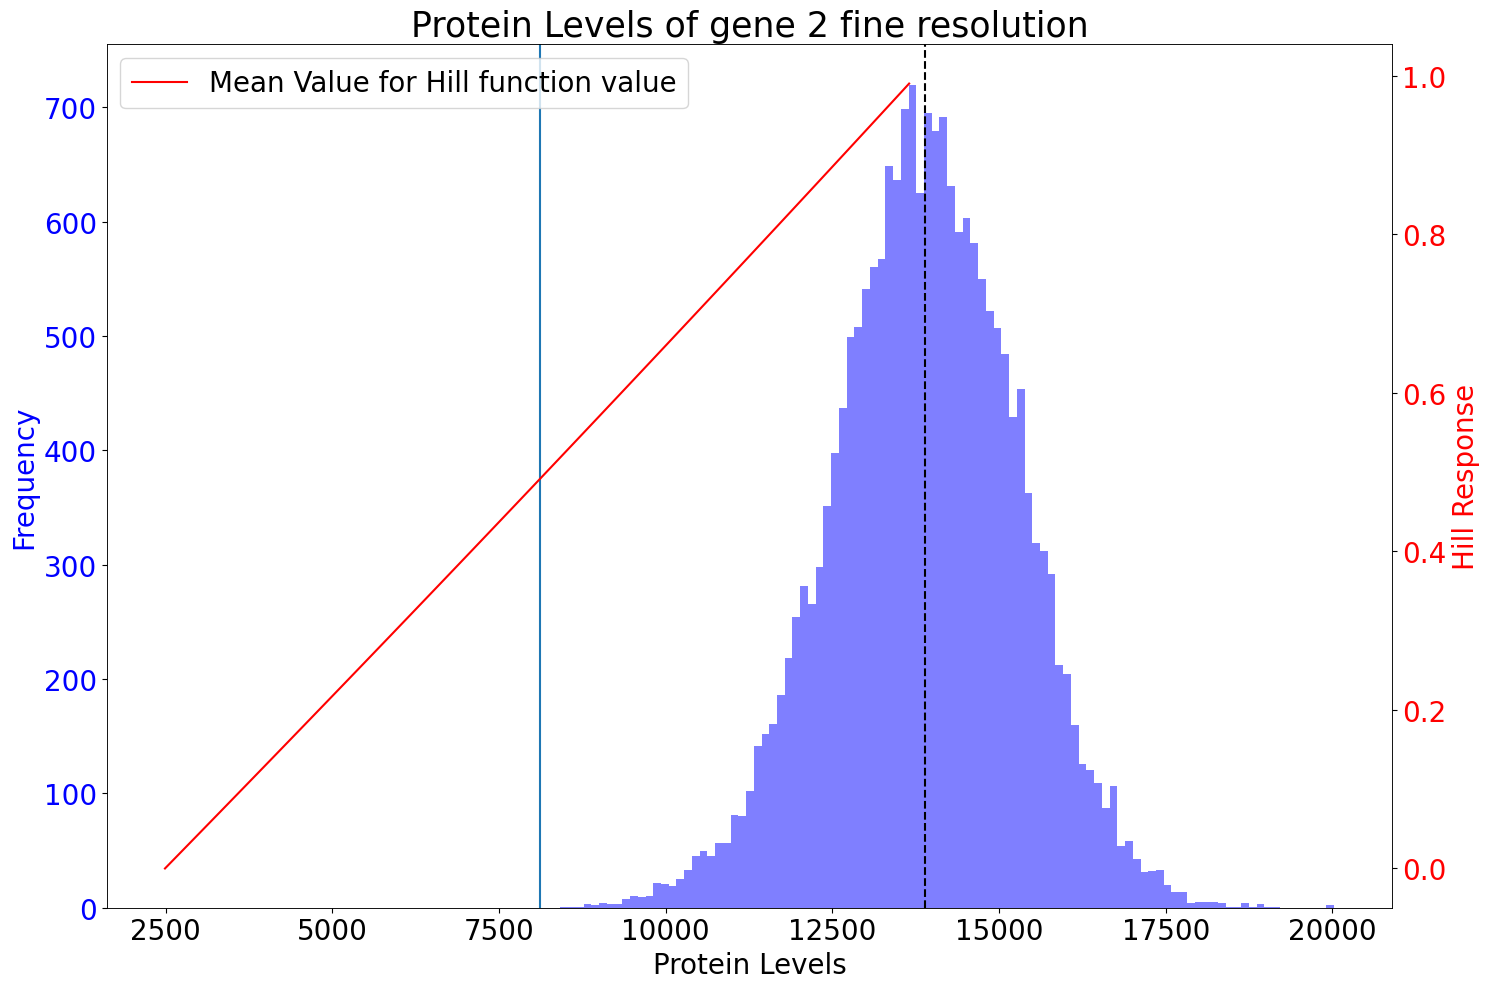

In [82]:

fig, ax1 = plt.subplots()

# Plot histogram on the first y-axis
ax1.hist(singleTime_df['gene_2_protein'], bins=100, alpha=0.5, label='gene 2 protein', color='blue')
ax1.set_xlabel('Protein Levels')
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.axvline(singleTime_df['gene_2_protein'].mean(), label = "Actual mean", linestyle = "--", color = "black")
ax1.axvline(K_gene_2, label = "Theoretical mean")

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(different_levels_of_reg_df['Protein_Level'], different_levels_of_reg_df['Hill_Response'], color='red', label='Mean Value for Hill function value')
ax2.set_ylabel('Hill Response', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title("Protein Levels of gene 2 fine resolution")
fig.tight_layout()
plt.legend()
plt.show()

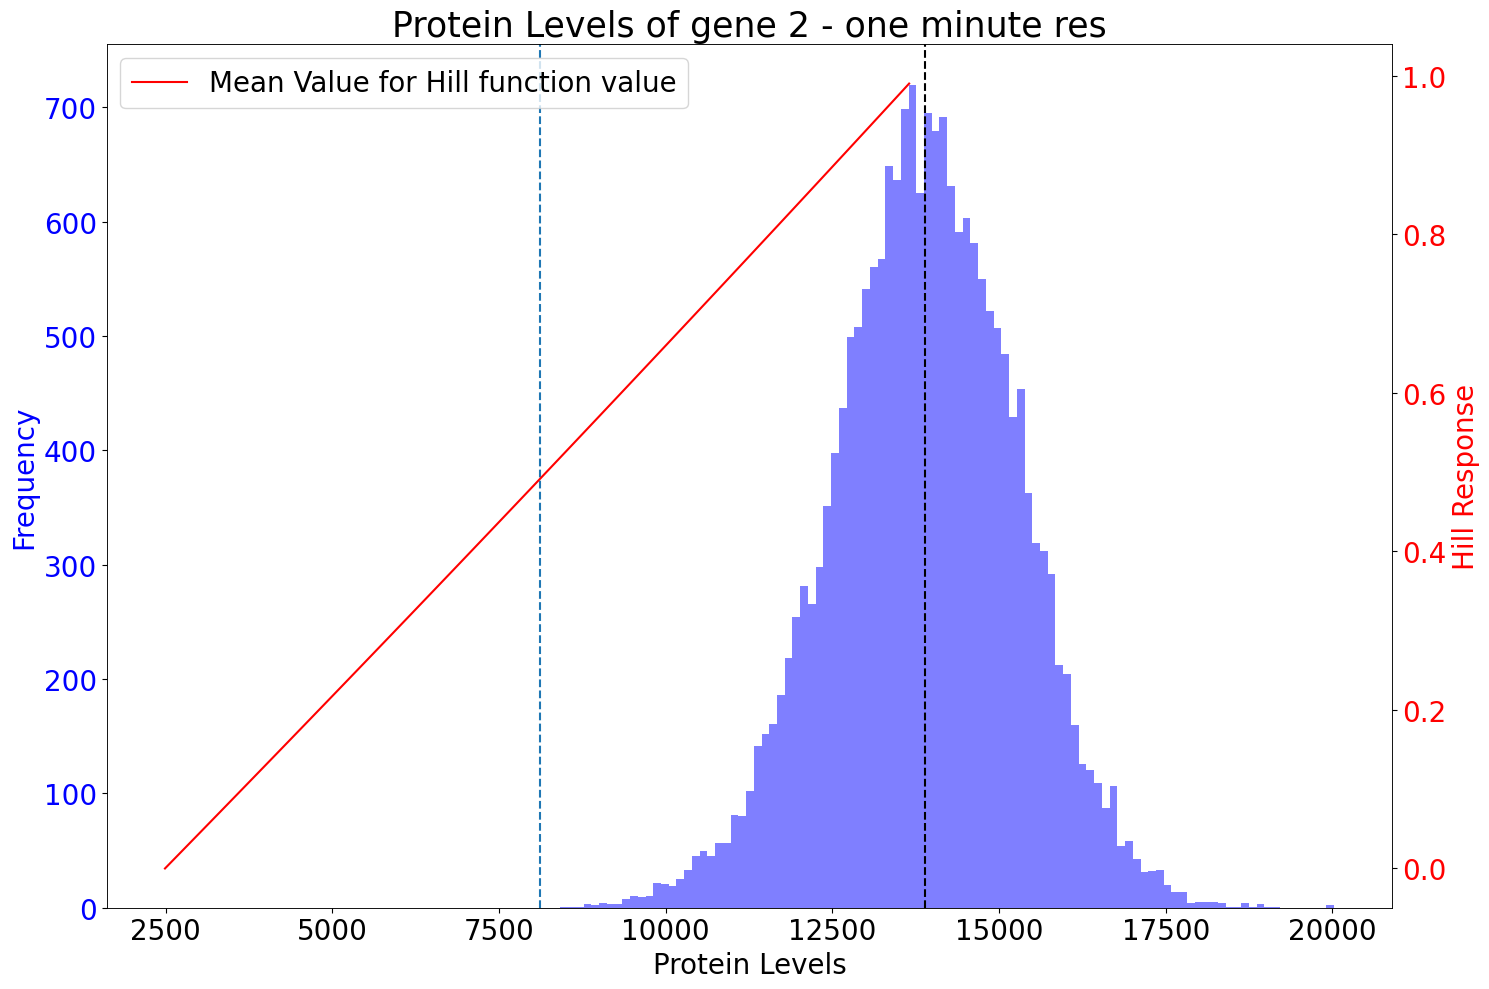

In [83]:

fig, ax1 = plt.subplots()

# Plot histogram on the first y-axis
ax1.hist(singleTime_df['gene_2_protein'], bins=100, alpha=0.5, label='gene 2 protein', color='blue')
ax1.set_xlabel('Protein Levels')
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.axvline(singleTime_df['gene_2_protein'].mean(), label = "Actual mean", linestyle = "--", color = "black")
ax1.axvline(K_gene_2, label = "Theoretical mean", linestyle = "--")
# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(different_levels_of_reg_df['Protein_Level'], different_levels_of_reg_df['Hill_Response'], color='red', label='Mean Value for Hill function value')
ax2.set_ylabel('Hill Response', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title("Protein Levels of gene 2 - one minute res")
fig.tight_layout()
plt.legend()
plt.show()

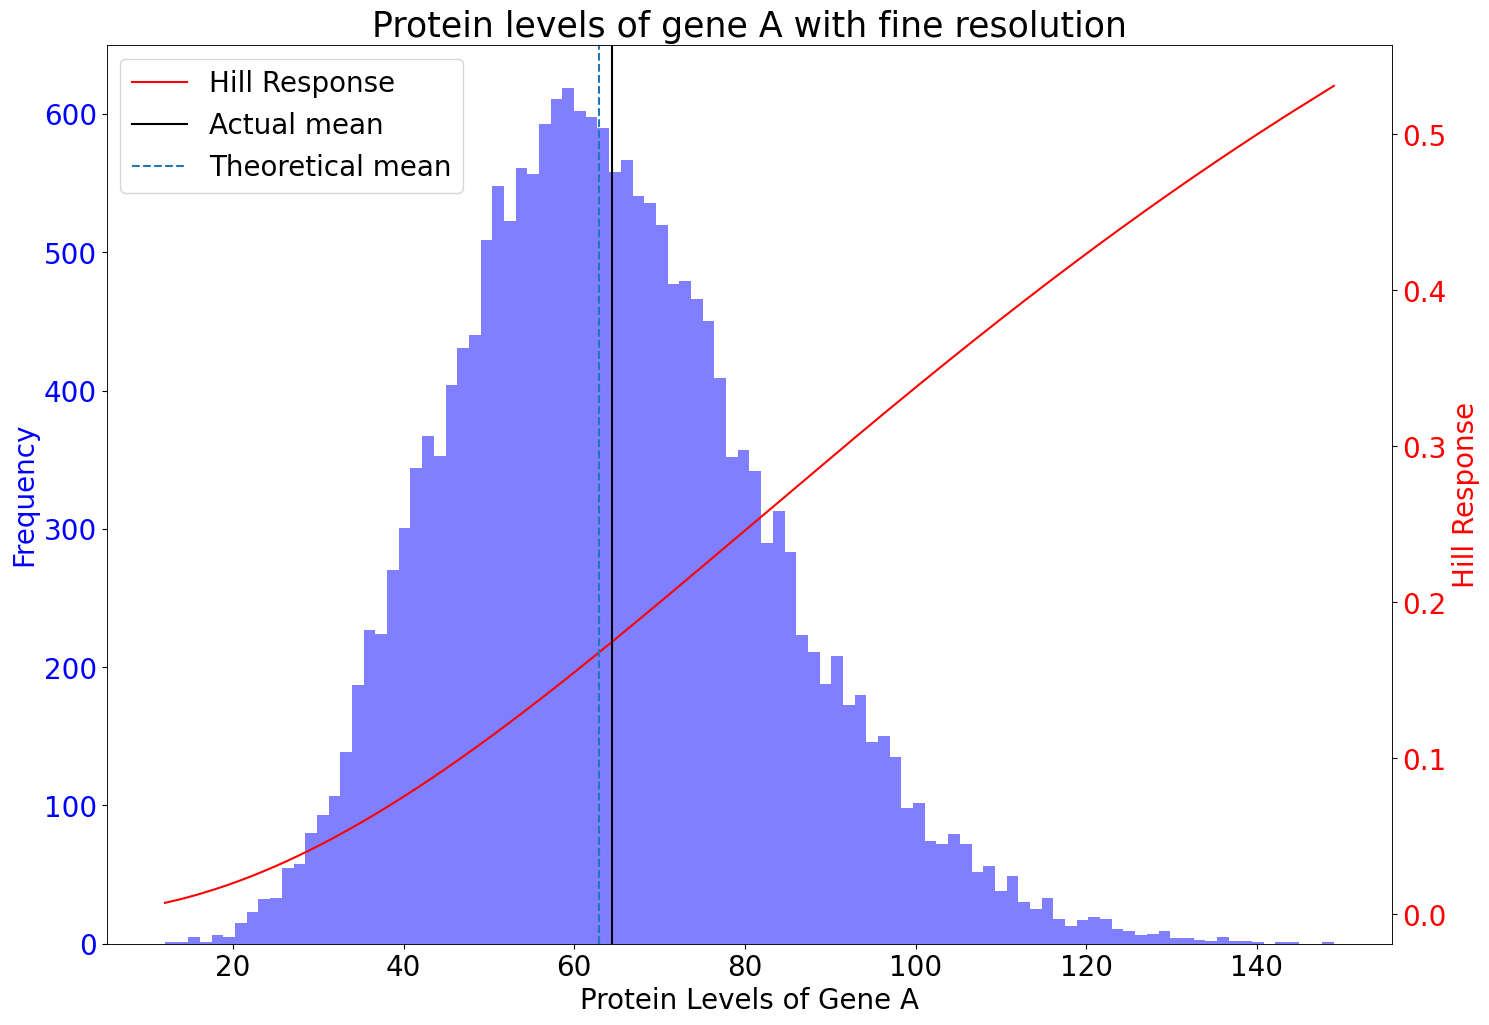

In [71]:
fig, ax1 = plt.subplots()

# Plot histogram on the first y-axis
ax1.hist(singleTime_df['gene_1_protein'], bins=100, alpha=0.5, label='gene 1 protein', color='blue')
ax1.set_xlabel('Protein Levels of Gene A')
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(gene_1, hill_gene_1, color='red', label='Hill Response')
ax2.axvline(singleTime_df['gene_1_protein'].mean(), label = "Actual mean", color = "black")
ax2.axvline(baseline_gene_1, label = "Theoretical mean", linestyle = "--")
ax2.set_ylabel('Hill Response', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.legend()
fig.tight_layout()
plt.title("Protein levels of gene A with fine resolution")
plt.show()

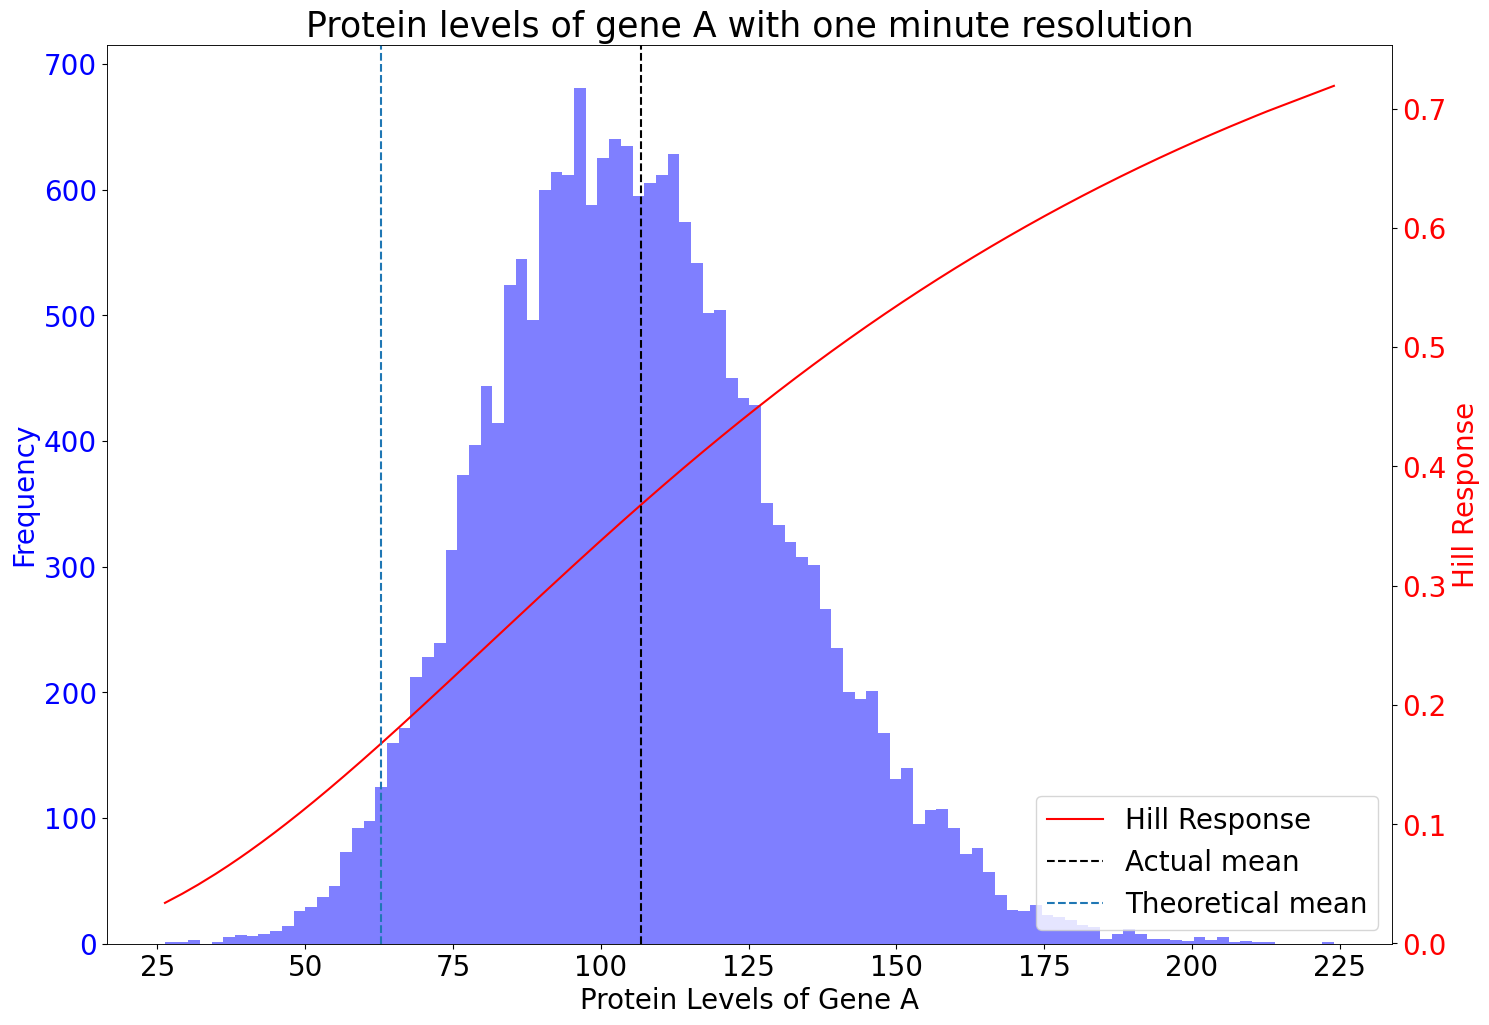

In [84]:
fig, ax1 = plt.subplots()

# Plot histogram on the first y-axis
ax1.hist(singleTime_df['gene_1_protein'], bins=100, alpha=0.5, label='gene 1 protein', color='blue')
ax1.set_xlabel('Protein Levels of Gene A')
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(gene_1, hill_gene_1, color='red', label='Hill Response')
ax2.axvline(singleTime_df['gene_1_protein'].mean(), label = "Actual mean", linestyle = "--", color = "black")
ax2.axvline(baseline_gene_1, label = "Theoretical mean", linestyle = "--")
ax2.set_ylabel('Hill Response', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.legend()
fig.tight_layout()
plt.title("Protein levels of gene A with one minute resolution")
plt.show()

In [85]:
print(np.mean(singleTime_df['gene_1_protein'].values), baseline_gene_1)
print(np.mean(singleTime_df['gene_2_protein'].values), K_gene_2)

106.8553449439194 62.88215236008717
13886.594377180707 8110.351616560633


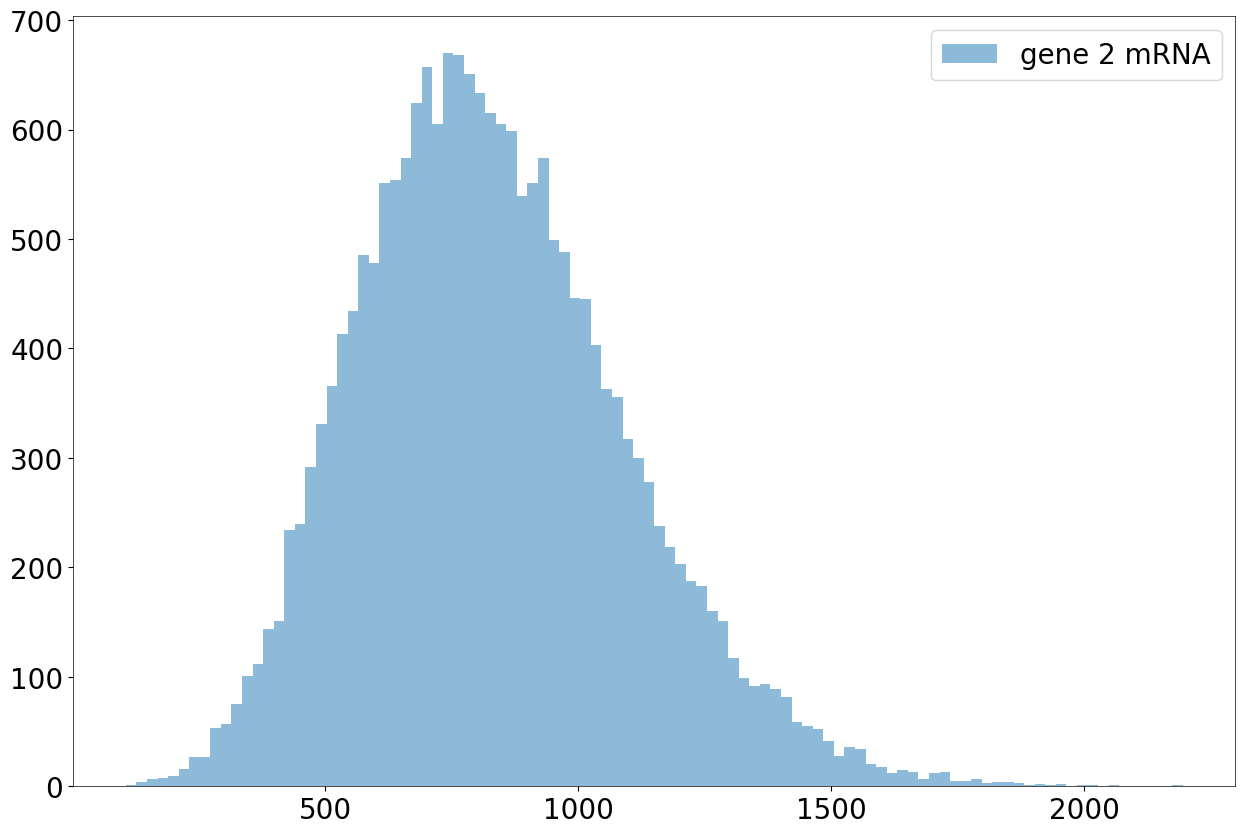

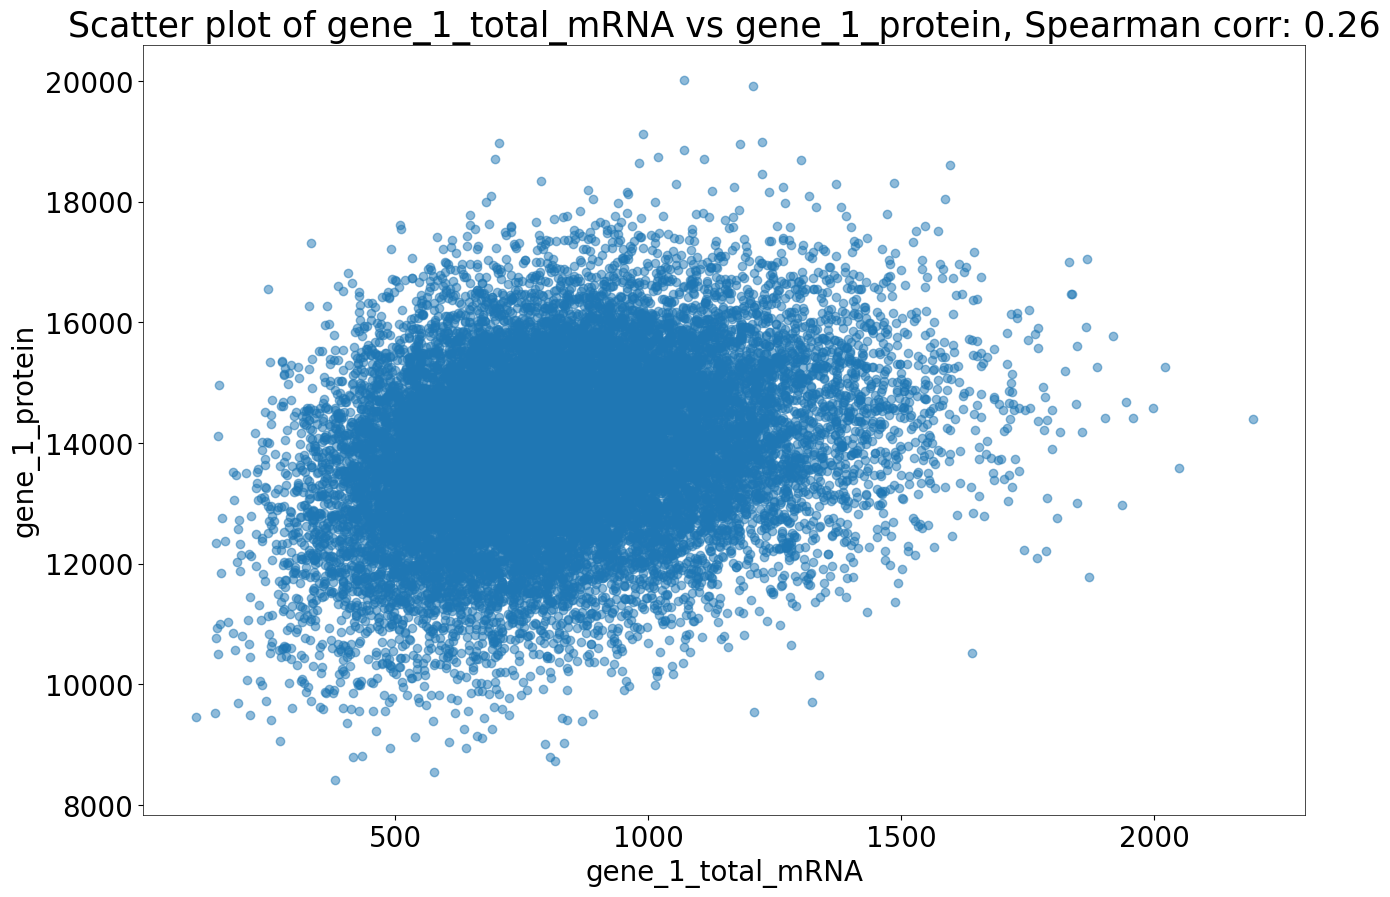

In [87]:
#First compare regulation
time = 300
singleTime_df = updated_df[updated_df['timestep'] == time]
singleTime_df = singleTime_df.reset_index(drop=True)

plt.hist(singleTime_df['gene_2_total_mRNA'], bins=100, alpha=0.5, label='gene 2 mRNA')
# plt.hist(singleTime_df['gene_3_total_mRNA'], bins=100, alpha=0.5, label='gene 3 mRNA')
plt.legend(loc='upper right')
plt.show()

plt.scatter(singleTime_df['gene_2_total_mRNA'], singleTime_df['gene_2_protein'], alpha=0.5)
corr = spearmanr(singleTime_df['gene_2_total_mRNA'], singleTime_df['gene_2_protein'])
plt.ylabel('gene_1_protein')
plt.xlabel('gene_1_total_mRNA')
plt.title('Scatter plot of gene_1_total_mRNA vs gene_1_protein, Spearman corr: {:.2f}'.format(corr.correlation))
plt.show()

# plt.scatter(singleTime_df['gene_2_protein'], singleTime_df['gene_3_total_mRNA'], alpha=0.5)
# corr = spearmanr(singleTime_df['gene_2_protein'], singleTime_df['gene_3_total_mRNA'])
# plt.ylabel('gene_3_total_mRNA')
# plt.xlabel('gene_2_protein')
# plt.title('Scatter plot of gene_2_protein vs gene_3_total_mRNA, Spearman corr: {:.2f}'.format(corr.correlation))
# plt.show()

# plt.scatter(singleTime_df['gene_2_total_mRNA'], singleTime_df['gene_3_total_mRNA'], alpha=0.5)
# corr = spearmanr(singleTime_df['gene_2_total_mRNA'], singleTime_df['gene_3_total_mRNA'])
# plt.ylabel('gene_3_total_mRNA')
# plt.xlabel('gene_2_total_mRNA')
# plt.title('Scatter plot of gene_2_total_mRNA vs gene_3_total_mRNA, Spearman corr: {:.2f}'.format(corr.correlation))
# plt.show()

In [9]:
updated_df

,cell_id,time_step,gene_1_mRNA,gene_1_protein,gene_2_mRNA,gene_2_protein,replicate,clone_id
0,0,0,0,49,12,23774,1,0
1,0,1,0,49,12,23731,1,0
2,0,2,0,48,10,23654,1,0
3,0,3,0,48,8,23561,1,0
4,0,4,0,48,9,23479,1,0
...,...,...,...,...,...,...,...,...
959995,19999,43,0,21,7,13654,2,9999
959996,19999,44,0,21,3,13581,2,9999
959997,19999,45,0,21,2,13448,2,9999
959998,19999,46,0,21,2,13340,2,9999


In [19]:
singleTime_df

,cell_id,time_step,gene_1_mRNA,gene_1_protein,gene_2_mRNA,gene_2_protein,replicate,clone_id
5,0,5,0,4504,0,0,1,0
53,1,5,0,3448,0,0,1,1
101,2,5,0,3041,0,0,1,2
149,3,5,1,6063,0,0,1,3
197,4,5,1,1465,0,0,1,4
...,...,...,...,...,...,...,...,...
959765,19995,5,0,8236,0,0,2,9995
959813,19996,5,0,2919,0,0,2,9996
959861,19997,5,0,6810,0,0,2,9997
959909,19998,5,0,4608,0,0,2,9998


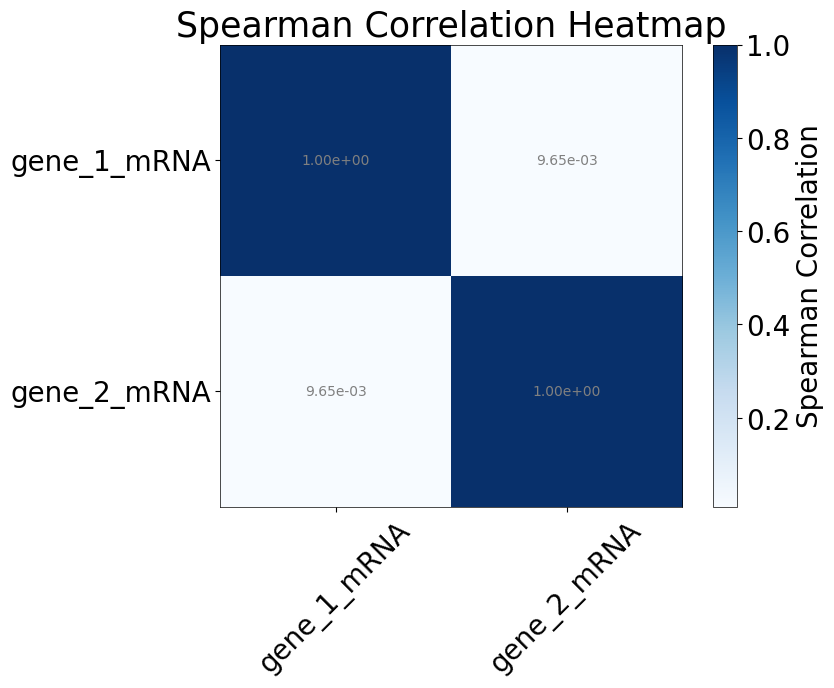

In [36]:
# BEGIN: Generate correlation matrix and plot heatmap with labels
# Ensure the correlation matrix contains numeric values
time = 5
singleTime_df = updated_df[updated_df['time_step'] == time]
n_genes = 2
columns_interest = ['gene_{}_mRNA'.format(i) for i in range(1, n_genes + 1)]
correlation_matrix = singleTime_df[columns_interest].corr(method='spearman')
correlation_matrix = correlation_matrix.astype(float)

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar(label='Spearman Correlation')
plt.xticks(ticks=range(len(correlation_matrix)), labels=correlation_matrix.columns, rotation=45)
plt.yticks(ticks=range(len(correlation_matrix)), labels=correlation_matrix.index)

plt.title('Spearman Correlation Heatmap')

# Annotate the heatmap with correlation values
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2e}",
                 ha="center", va="center", color="grey")

plt.show()
# END: Generate correlation matrix and plot heatmap with labels


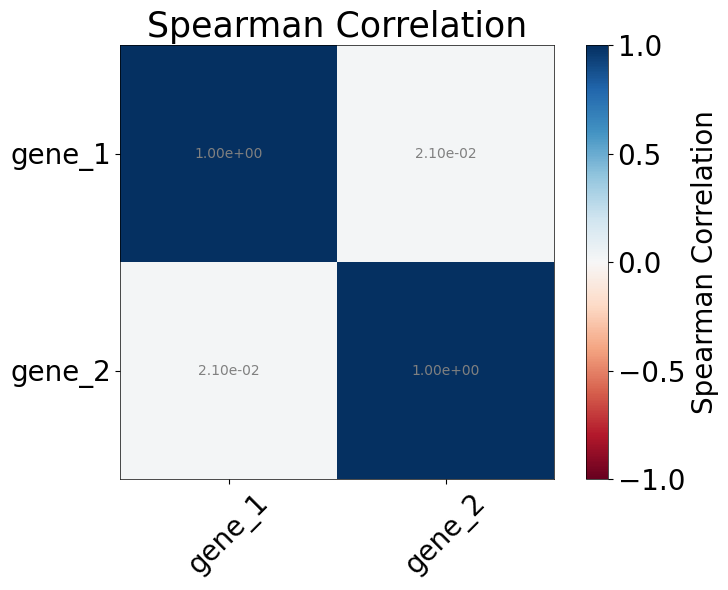

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ----- Parameters -----
time = 10
n_genes = 2
gene_list = [f"gene_{i}" for i in range(1, n_genes + 1)]
columns_interest = [f"{gene}_mRNA" for gene in gene_list]


# Assume updated_df is already defined and contains 'replicate', 'timestep', and mRNA columns
singleTime_df = updated_df[updated_df['time_step'] == time]

# Split into replicates
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1].reset_index(drop=True)
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2].reset_index(drop=True)

# ----- Step 1: Compute correlations -----
def calculate_correlation(rep_0, rep_1):
    correlations = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            delta_1 = rep_0[f"{gene_1}_mRNA"] - rep_1[f"{gene_1}_mRNA"]
            delta_2 = rep_0[f"{gene_2}_mRNA"] - rep_1[f"{gene_2}_mRNA"]
            corr = spearmanr(delta_1, delta_2).correlation
            correlations[f"{gene_1}-{gene_2}"] = corr
    return correlations

# ----- Step 2: Convert to matrix -----
def dict_to_matrix(correlation_dict, gene_list):
    
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("-")
        matrix.loc[g1, g2] = value
    return matrix

# Compute correlation matrix
correlation_dict = calculate_correlation(rep_0_t1, rep_1_t1)
correlation_matrix = dict_to_matrix(correlation_dict, gene_list)

# ----- Step 3: Plot heatmap -----
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix.values, interpolation='nearest', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Spearman Correlation')
plt.xticks(ticks=range(len(gene_list)), labels=gene_list, rotation=45)
plt.yticks(ticks=range(len(gene_list)), labels=gene_list)
plt.title('Spearman Correlation')

# Annotate each cell with correlation value
for i in range(len(gene_list)):
    for j in range(len(gene_list)):
        val = correlation_matrix.iloc[i, j]
        if pd.notnull(val):
            plt.text(j, i, f"{val:.2e}", ha='center', va='center', color='grey')

plt.tight_layout()
plt.show()


/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning

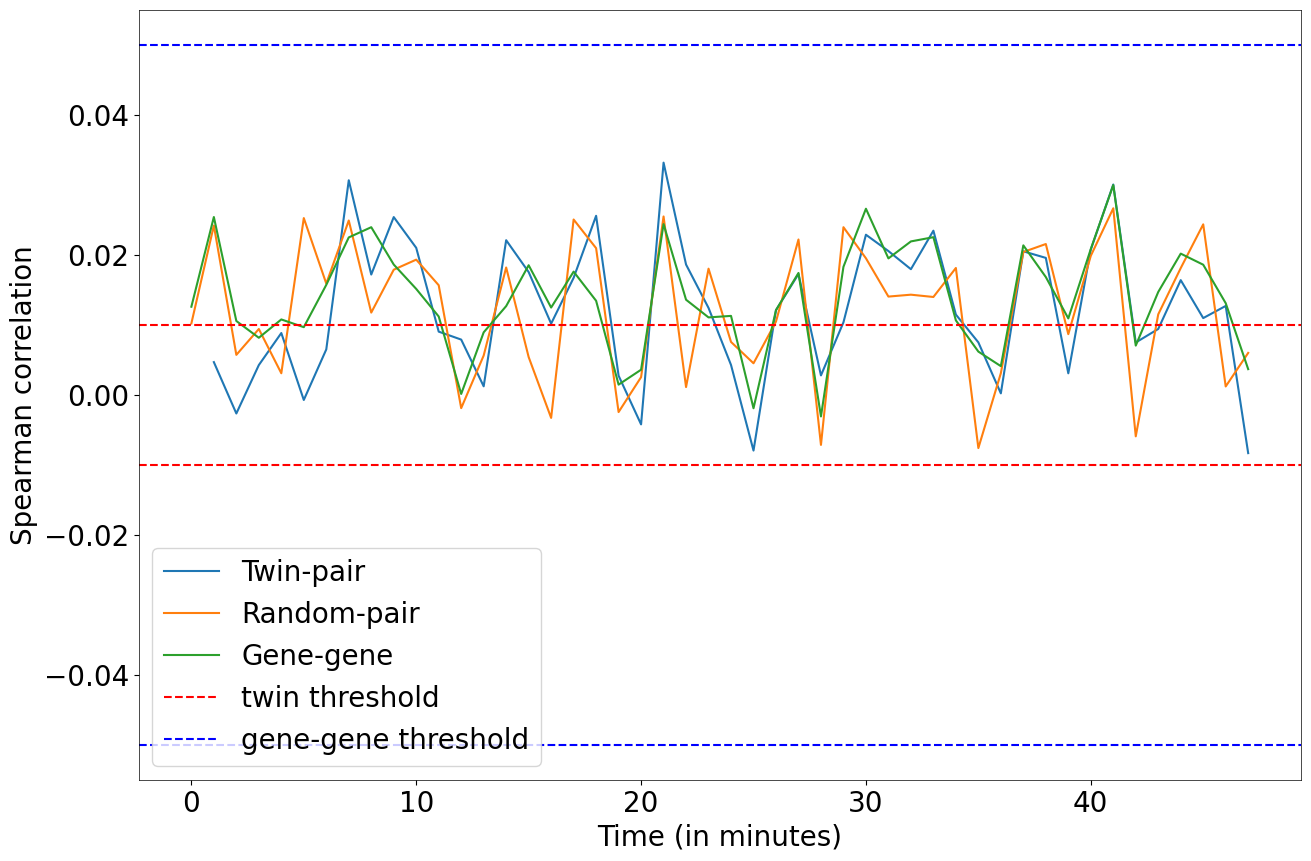

In [38]:
# updated_df = updated_df[updated_df['timestep'] < 1500]
time_points = updated_df['time_step'].unique()
n_genes = 2
gene_list = [f"gene_{i}" for i in range(1, n_genes + 1)]
columns_interest = [f"{gene}_mRNA" for gene in gene_list]
corr_list = []
rand_corr_list = []
gene_corr = []
# ----- Step 1: Compute correlations -----
def calculate_correlation(rep_0, rep_1):
    correlations = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            delta_1 = rep_0[f"{gene_1}_mRNA"] - rep_1[f"{gene_1}_mRNA"]
            delta_2 = rep_0[f"{gene_2}_mRNA"] - rep_1[f"{gene_2}_mRNA"]
            corr = spearmanr(delta_1, delta_2).correlation
            correlations[f"{gene_1}-{gene_2}"] = corr
    return correlations

# ----- Step 2: Convert to matrix -----
def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("-")
        matrix.loc[g1, g2] = value
    return matrix

for time in time_points:
    # if time > 1500:
    #     continue
    # Assume updated_df is already defined and contains 'replicate', 'timestep', and mRNA columns
    singleTime_df = updated_df[updated_df['time_step'] == time]
    gene_gene_corr = spearmanr(singleTime_df['gene_1_mRNA'], singleTime_df['gene_2_mRNA']).correlation
    # Split into replicates
    rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1].reset_index(drop=True)
    rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2].reset_index(drop=True)
    rep_shuffled_t1 = rep_1_t1.sample(frac = 1).reset_index(drop=True)


    # Compute correlation matrix
    correlation_dict = calculate_correlation(rep_0_t1, rep_1_t1)
    corr_rand_dict = calculate_correlation(rep_0_t1, rep_shuffled_t1)
    corr_list.append(correlation_dict['gene_1-gene_2'])
    rand_corr_list.append(corr_rand_dict['gene_1-gene_2'])
    gene_corr.append(gene_gene_corr)

plt.plot(time_points, corr_list, label = "Twin-pair")
plt.plot(time_points, rand_corr_list, label = "Random-pair")
plt.plot(time_points, gene_corr, label = "Gene-gene")
plt.xlabel('Time (in minutes)')
plt.ylabel('Spearman correlation')
plt.axhline(0.01, linestyle = "--",  color = "red",label = "twin threshold")
plt.axhline(-0.01, linestyle = "--",  color = "red",)
plt.axhline(0.05, linestyle = "--", color = "blue", label = "gene-gene threshold")
plt.axhline(-0.05, linestyle = "--", color = "blue",)
plt.legend()
plt.show()


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def shrink_arrow_endpoints(x1, y1, x2, y2, shrink_source=0.25, shrink_target=0.25, lateral_offset=0.0):
    dx, dy = x2 - x1, y2 - y1
    dist = np.hypot(dx, dy)
    if dist == 0:
        return (x1, y1), (x2, y2)
    
    ux, uy = dx / dist, dy / dist  # unit vector
    orth_x, orth_y = -uy, ux  # orthogonal vector
    
    # Apply lateral shift outward
    x1_off = x1 + shrink_source * ux + lateral_offset * orth_x
    y1_off = y1 + shrink_source * uy + lateral_offset * orth_y
    x2_off = x2 - shrink_target * ux + lateral_offset * orth_x
    y2_off = y2 - shrink_target * uy + lateral_offset * orth_y

    return (x1_off, y1_off), (x2_off, y2_off)

def flat_t_head_arrow(start, end, color='red', linewidth=2, rad=0.2, ax=None):
    """Draws a repression-style arrow with a flat T-head."""
    arrow = FancyArrowPatch(
        start, end,
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle='-',
        color=color,
        linewidth=linewidth,
        zorder=1
    )
    ax.add_patch(arrow)

    x1, y1 = start
    x2, y2 = end
    dx, dy = x2 - x1, y2 - y1
    dist = np.hypot(dx, dy)
    if dist == 0:
        return
    ux, uy = dx / dist, dy / dist
    tx, ty = x2, y2
    px, py = -uy, ux
    t_len = 0.05
    t_xs = [tx - px * t_len, tx + px * t_len]
    t_ys = [ty - py * t_len, ty + py * t_len]
    ax.plot(t_xs, t_ys, color=color, linewidth=linewidth, solid_capstyle='round', zorder=2)

def plot_gene_correlation_network(correlation_matrix, gene_list, title=None):
    DG = nx.DiGraph()
    for gene in gene_list:
        DG.add_node(gene)

    for gene_1 in gene_list:
        self_corr = correlation_matrix.loc[gene_1, gene_1]
        if self_corr == 0 or np.isnan(self_corr):
            continue
        for gene_2 in gene_list:
            if gene_1 == gene_2:
                continue
            raw_weight = correlation_matrix.loc[gene_1, gene_2]
            if pd.isnull(raw_weight):
                continue
            norm_weight = raw_weight / self_corr
            if abs(raw_weight) > 0.05:
                DG.add_edge(gene_1, gene_2, weight=norm_weight)

    pos = nx.spring_layout(DG, seed=42)
    node_colors = np.array([correlation_matrix.loc[gene, gene] for gene in gene_list])
    norm = Normalize(vmin=0, vmax=max(node_colors))
    cmap = plt.cm.Reds
    node_rgba = cmap(norm(node_colors))
    node_rgba[:, -1] = 0.5

    fig, ax = plt.subplots(figsize=(9, 9))
    nx.draw_networkx_nodes(DG, pos, ax=ax, node_color=node_rgba, node_size=4000,
                           edgecolors='black', linewidths=1.5)
    nx.draw_networkx_labels(DG, pos, font_size=14, font_weight='bold', ax=ax)

    for u, v in DG.edges():
        weight = DG[u][v]['weight']
        abs_weight = abs(weight)
        color = 'blue' if weight > 0 else 'red'
        rad = 0.25 if DG.has_edge(v, u) else 0.0

        x1, y1 = pos[u]
        x2, y2 = pos[v]
        arrow_offset = -0.2
        start, end = shrink_arrow_endpoints(x1, y1, x2, y2, lateral_offset=arrow_offset)


        if weight > 0:
            arrow = FancyArrowPatch(
                start, end,
                connectionstyle=f'arc3,rad={rad}',
                arrowstyle='-|>',
                mutation_scale=20 + abs_weight * 10,
                color=color,
                linewidth=max(abs_weight * 15, 1.0),
                zorder=1
            )
            ax.add_patch(arrow)
        else:
            flat_t_head_arrow(start, end, color=color, linewidth=max(abs_weight * 15, 1.0), rad=rad, ax=ax)

        # Label placement
        dx, dy = x2 - x1, y2 - y1
        xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
        vec = np.array([dx, dy])
        vec /= np.linalg.norm(vec)
        normal_vec = -1 * np.array([-dy, dx])
        normal_vec /= np.linalg.norm(normal_vec)
        label_offset = 0.7
        direction_bias = 0.10
        bias = direction_bias * vec
        offset_vec = label_offset * normal_vec + bias
        x_label = xm + offset_vec[0]
        y_label = ym + offset_vec[1]
        ax.text(x_label, y_label, f"{weight:.2e}", fontsize=10, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='gray', lw=0.5))

    sm = ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Self Correlation (gene → gene)', fontsize=12)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()

    if len(pos) > 0:
        x_vals, y_vals = zip(*pos.values())
        if all(np.isfinite(x_vals)) and all(np.isfinite(y_vals)):
            x_range = max(x_vals) - min(x_vals)
            y_range = max(y_vals) - min(y_vals)
            x_margin = 0.3 * x_range if x_range > 0 else 1
            y_margin = 0.3 * y_range if y_range > 0 else 1
            ax.set_xlim(min(x_vals) - x_margin, max(x_vals) + x_margin)
            ax.set_ylim(min(y_vals) - y_margin, max(y_vals) + y_margin)

    plt.show()


In [13]:
def plot_gene_correlation_network(correlation_matrix, gene_list, title=None):
    DG = nx.DiGraph()
    for gene in gene_list:
        DG.add_node(gene)

    for gene_1 in gene_list:
        self_corr = correlation_matrix.loc[gene_1, gene_1]
        if self_corr == 0 or np.isnan(self_corr):
            continue
        for gene_2 in gene_list:
            if gene_1 == gene_2:
                continue
            raw_weight = correlation_matrix.loc[gene_1, gene_2]
            if pd.isnull(raw_weight):
                continue
            norm_weight = raw_weight / self_corr
            if abs(raw_weight) > 0.05:
                DG.add_edge(gene_1, gene_2, weight=norm_weight)

    pos = nx.spring_layout(DG, seed=42)
    node_colors = np.array([correlation_matrix.loc[gene, gene] for gene in gene_list])
    node_norm = Normalize(vmin=0, vmax=max(node_colors))
    node_cmap = plt.cm.Blues
    node_rgba = node_cmap(node_norm(node_colors))
    node_rgba[:, -1] = 0.5

    # Normalize edge weights
    edge_weights = [abs(DG[u][v]['weight']) for u, v in DG.edges()]
    if edge_weights:
        edge_norm = Normalize(vmin=0, vmax=max(edge_weights))
    else:
        edge_norm = Normalize(vmin=0, vmax=1)

    fig, ax = plt.subplots(figsize=(9, 9))
    nx.draw_networkx_nodes(DG, pos, ax=ax, node_color=node_rgba, node_size=4000,
                           edgecolors='black', linewidths=1.5)
    labels = {gene: chr(64 + int(gene.replace('gene_', ''))) for gene in DG.nodes()}

    nx.draw_networkx_labels(DG, pos, labels=labels, font_size=24, font_weight='bold', ax=ax)

    for u, v in DG.edges():
        weight = DG[u][v]['weight']
        color = node_cmap(edge_norm(abs(weight)))
        rad = 0.25 if DG.has_edge(v, u) else 0.0

        x1, y1 = pos[u]
        x2, y2 = pos[v]

        arrow_offset = -0.2 if DG.has_edge(v, u) else 0.0
        start, end = shrink_arrow_endpoints(x1, y1, x2, y2, lateral_offset=arrow_offset)

        if weight > 0:
            arrow = FancyArrowPatch(
                start, end,
                connectionstyle=f'arc3,rad={rad}',
                arrowstyle='-|>',
                mutation_scale=20 + abs(weight) * 10,
                color=color,
                linewidth=max(abs(weight) * 15, 1.0),
                zorder=1
            )
            ax.add_patch(arrow)
        else:
            flat_t_head_arrow(start, end, color=color, linewidth=max(abs(weight) * 15, 1.0), rad=rad, ax=ax)

        dx, dy = x2 - x1, y2 - y1
        xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
        vec = np.array([dx, dy])
        vec /= np.linalg.norm(vec)
        normal_vec = -1 * np.array([-dy, dx])
        normal_vec /= np.linalg.norm(normal_vec)
        label_offset = 0.7
        direction_bias = 0.10
        bias = direction_bias * vec
        offset_vec = label_offset * normal_vec + bias
        x_label = xm + offset_vec[0]
        y_label = ym + offset_vec[1]
        ax.text(x_label, y_label, f"{weight:.2e}", fontsize=10, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='gray', lw=0.5))

    sm = ScalarMappable(norm=edge_norm, cmap=node_cmap)
    cbar = fig.colorbar(sm, ax=ax)
    # cbar.set_label('Normalized Correlation Magnitude', fontsize=12)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()

    if len(pos) > 0:
        x_vals, y_vals = zip(*pos.values())
        if all(np.isfinite(x_vals)) and all(np.isfinite(y_vals)):
            x_range = max(x_vals) - min(x_vals)
            y_range = max(y_vals) - min(y_vals)
            x_margin = 0.3 * x_range if x_range > 0 else 1
            y_margin = 0.3 * y_range if y_range > 0 else 1
            ax.set_xlim(min(x_vals) - x_margin, max(x_vals) + x_margin)
            ax.set_ylim(min(y_vals) - y_margin, max(y_vals) + y_margin)

    plt.show()


In [36]:
correlations

{'gene_1->gene_1': 0.5919303669184259,
 'gene_1->gene_2': 0.2108664834895962,
 'gene_2->gene_1': 0.1864313075688683,
 'gene_2->gene_2': 0.8803169749392712}

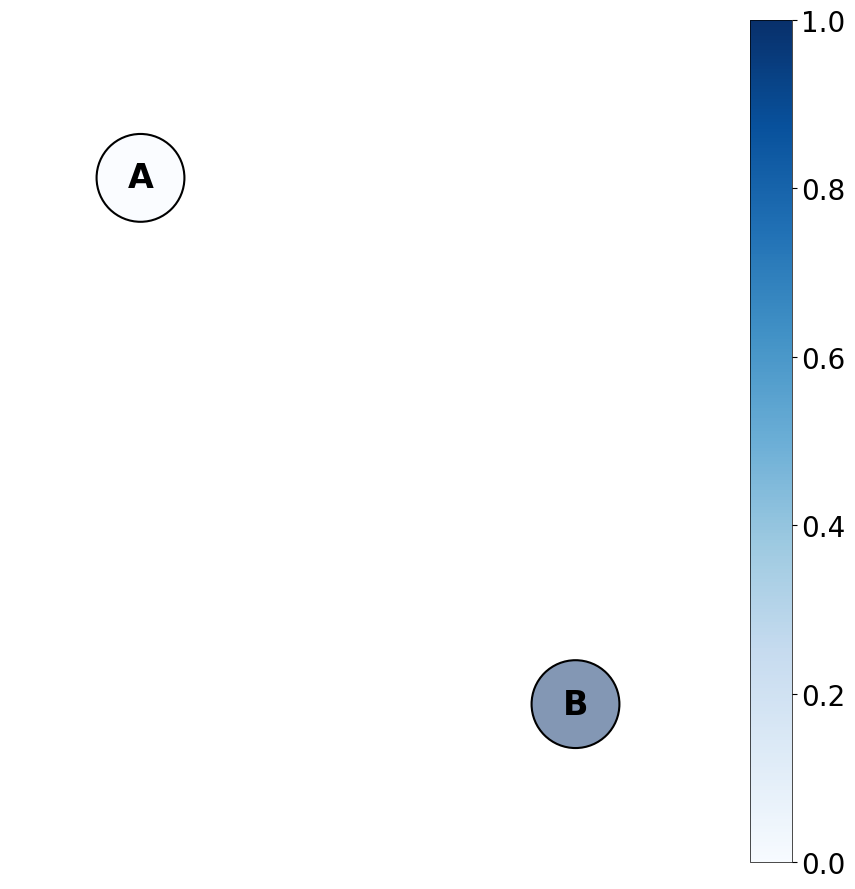

In [39]:
from matplotlib.patches import FancyArrowPatch
import networkx as nx

t1 = 5
singleTime_df = updated_df[updated_df['time_step'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
t2 = 15
singleTime_df = updated_df[updated_df['time_step'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
n_genes = 2
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

correlations = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
correlation_matrix = dict_to_matrix(correlations, gene_list)
plot_gene_correlation_network(correlation_matrix, gene_list)

Spearman Correlations between time points:
gene_1->gene_1: -1.71e-02
gene_1->gene_2: nan
gene_2->gene_1: nan
gene_2->gene_2: nan


/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


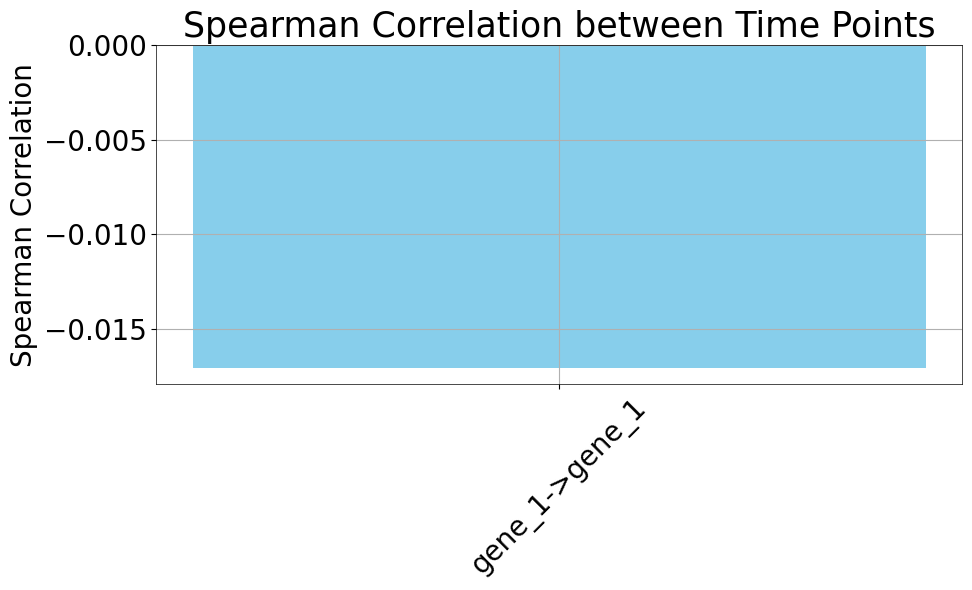

In [23]:
t1 = 5
singleTime_df = updated_df[updated_df['time_step'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
t2 = 10
singleTime_df = updated_df[updated_df['time_step'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
n_genes = 2
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]
#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            # correlations_normalised[f"{gene_1}->{gene_2}"] = correlations[f"{gene_1}->{gene_2}"]/correlations[f"{gene_1}->{gene_1}"]
            correlations_normalised[f"{gene_1}->{gene_2}"] = correlations[f"{gene_1}->{gene_2}"]

    return correlations, correlations_normalised

correlations, correlations_normalised = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
# Print the correlations
print("Spearman Correlations between time points:")
for gene, corr in correlations_normalised.items():
    print(f"{gene}: {corr:.2e}")
# Plotting the correlations
plt.figure(figsize=(10, 6))
plt.bar(correlations_normalised.keys(), correlations_normalised.values(), color='skyblue')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation between Time Points')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()
# #Plot it as a matrix
# correlation_matrix = pd.DataFrame(correlations_normalised)
# # for gene_1 in gene_list:
# #     for gene_2 in gene_list:
# #         corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_total_mRNA"], rep_1_t2[f"{gene_2}_total_mRNA"]).correlation
# #         correlation_matrix.loc[gene_1, gene_2] = corr_t1_t2

# import matplotlib.pyplot as plt
# import networkx as nx
# import numpy as np

# # Create directed graph
# DG = nx.DiGraph()

# # Add nodes
# for gene in gene_list:
#     DG.add_node(gene)

# # Add directed edges with weights
# for gene_1 in gene_list:
#     for gene_2 in gene_list:
#         if gene_1 != gene_2:
#             weight = correlation_matrix.loc[gene_1, gene_2]
#             DG.add_edge(gene_1, gene_2, weight=weight)

# # Circular layout
# pos = nx.circular_layout(DG)

# plt.figure(figsize=(8, 8))
# nx.draw_networkx_nodes(DG, pos, node_color='skyblue', node_size=1000)
# nx.draw_networkx_labels(DG, pos, font_size=10, font_weight='bold')

# # Draw curved edges with arrowheads
# for u, v in DG.edges():
#     weight = abs(DG[u][v]['weight']) * 20
#     color = 'blue' if DG[u][v]['weight'] > 0 else 'red'
#     rad = 0.2 if DG.has_edge(v, u) else 0.0

#     nx.draw_networkx_edges(
#         DG, pos,
#         edgelist=[(u, v)],
#         connectionstyle=f'arc3,rad={rad}',
#         width=weight,
#         edge_color=color,
#         arrows=True,
#         arrowsize=25
#     )

# # Manually compute offset label positions
# label_pos = {}
# offset_scale = 0.08
# for u, v in DG.edges():
#     x1, y1 = pos[u]
#     x2, y2 = pos[v]
#     dx, dy = x2 - x1, y2 - y1
#     angle = np.arctan2(dy, dx)
#     offset_x = -offset_scale * np.sin(angle)
#     offset_y = offset_scale * np.cos(angle)
#     if DG.has_edge(v, u) and (v, u) in label_pos:
#         offset_x *= -1
#         offset_y *= -1
#     label_pos[(u, v)] = ((x1 + x2) / 2 + offset_x, (y1 + y2) / 2 + offset_y)

# # Draw edge labels manually using ax.text
# edge_labels = {(u, v): f"{d['weight']:.2e}" for u, v, d in DG.edges(data=True)}
# # Updated label draw loop
# # Draw two separate edge labels for each direction
# ax = plt.gca()
# drawn = set()
# for (u, v), label_uv in edge_labels.items():
#     if (u, v) in drawn:
#         continue

#     # Positions
#     x1, y1 = pos[u]
#     x2, y2 = pos[v]
#     mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
#     dx, dy = x2 - x1, y2 - y1
#     angle = np.arctan2(dy, dx)

#     # Perpendicular offset
#     offset = 0.1
#     ox = -offset * np.sin(angle)
#     oy = offset * np.cos(angle)

#     # Label for u → v
#     label_uv = edge_labels[(u, v)]
#     ax.text(
#         mid_x - ox, mid_y - oy,
#         label_uv,
#         fontsize=10, color='black', fontweight='bold',
#         ha='center', va='center',
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')
#     )

#     # Label for v → u, if it exists
#     if (v, u) in edge_labels:
#         label_vu = edge_labels[(v, u)]
#         ax.text(
#             mid_x + ox, mid_y + oy,
#             label_vu,
#             fontsize=10, color='black', fontweight='bold',
#             ha='center', va='center',
#             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')
#         )

#     drawn.add((u, v))
#     drawn.add((v, u))



# plt.title('Gene Correlation Network Multiplicative regulation', fontsize=14)
# plt.axis('off')
# plt.tight_layout()
# plt.show()

